# CNN - Convolutional Neural Network

Convolutional Neural Network, abreviado como CNN, é uma técnica do campo de Deep Leraning, ou seja, é uma implementação em redes neurais com multi camadas. O seu nome vem da operação matemática entre as camadas chamada de convolução {cite}`Albawi2017`.

Após a sua popularidade no campo de reconhecimento de imagens a partir do trabalho de {cite}`Krizhevsky2012`, a técnica de CNN foi expandida para demais aplicações. Devido a sua estrutura, o CNN tem sido aplicado em problemas de séries temporal {cite}`Yann1995,IsmailFawaz2019`.

Sendo assim, neste capítulo aplicamos o CNN para prever o total de vendas de tomdas, interruptores e pulsadores no ano de 2020 a partir das séries temporais selecionadas no [Passo 2](passo2.ipynb).

In [1]:
from numpy import array, hstack, vstack 
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D
from datetime import timedelta, date
from dateutil. relativedelta import relativedelta

from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

import keras
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dados = pd.read_csv('datasets/dados.csv')
dados = dados.rename(columns={'Unnamed: 0':'mes'})
dados = dados.set_index('mes')

No [Passo 2](passo2.ipynb), a partir do teste de Granger, as seguintes variáriveis foram escolhidas para entrarem no modelo:


In [3]:
dados = dados[['ibc','pib','consumo','ICST-R','geracaoGWh','IndGeral','total']]
dados.head()

,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral,total
mes,,,,,,,
2014-01-01,2.75,455935.0,40279759.0,97.8,50045.962407,53.1,13427897
2014-02-01,3.13,450358.8,41653487.0,96.7,46459.730274,52.3,14152120
2014-03-01,3.09,462159.8,40269429.0,96.3,48004.277170,52.4,13710770
2014-04-01,2.37,468767.5,39591854.0,92.6,45412.583753,49.2,12602895
2014-05-01,2.23,473347.1,39100499.0,94.6,44890.282526,47.9,14603442


Para implementar o algoritmo de machine learning como CNN, primeiro é necessário organizar os dados no formato adequado para entrada no modelo.

Podemos considerar cada variável (coluna do dataframe dados) como uma série temporal. Neste caso, teremos múltiplas séries como input e apenas uma série como output.

Para exemplificar, vamos considerar apenas as variáveis ibc, pib como input e a variável total como o output. Consideramos também apenas o período de jan/2014 a maio/2014.

In [4]:
in_seq1 = dados.loc['2014-01-01':'2014-05-01',['ibc']].to_numpy()
in_seq2 = dados.loc['2014-01-01':'2014-05-01',['pib']].to_numpy()
out_seq = dados.loc['2014-01-01':'2014-05-01',['total']].to_numpy()

In [5]:
dataset = hstack((in_seq1,in_seq2,out_seq))
print(dataset)
dataset.shape

[[2.7500000e+00 4.5593500e+05 1.3427897e+07]
 [3.1300000e+00 4.5035880e+05 1.4152120e+07]
 [3.0900000e+00 4.6215980e+05 1.3710770e+07]
 [2.3700000e+00 4.6876750e+05 1.2602895e+07]
 [2.2300000e+00 4.7334710e+05 1.4603442e+07]]


(5, 3)

Percebe-se que o dataset possui duas dimensões, a primeira com 5 linhas representando cada mês da série temporal e a segunda com 3 colunas, representando cada uma das variáveis.

Como a intenção é prever a última coluna (total de vendas), podemos escrever o seu valor como função das observações anteriores. Para tanto, devemos definir o número de passos (meses) para prever cada valor do total. Para facilitar esse procedimento a função a seguir é definida: baseado no trabalho de {cite}`Brownlee2018`

In [6]:
# split a multivariate sequence into samples 
def split_sequences(sequences, n_steps): 
    X, y = list(), list() 
    for i in range(len(sequences)): 
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the dataset 
        if end_ix == len(sequences): 
            break
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1] 
        X.append(seq_x) 
        y.append(seq_y)
    return array(X), array(y)

In [7]:
X,y= split_sequences(dataset, 2)
for i in range(0,3):
    print(X[i], '-->', y[i])
    print()


[[2.750000e+00 4.559350e+05]
 [3.130000e+00 4.503588e+05]] --> 13710770.0

[[3.130000e+00 4.503588e+05]
 [3.090000e+00 4.621598e+05]] --> 12602895.0

[[3.090000e+00 4.621598e+05]
 [2.370000e+00 4.687675e+05]] --> 14603442.0



Neste exemplo verificamos que o total de vendas 137+05 (março) será previsto em função do ibc e pib dos meses de janeiro e fevereiro. Já o total de vedas de abril (126+05) será previsto em relação às variáveis de fevereiro e março. Repare que, como o passo escolhido foi de 2 unidades, cada output será previsto em relação a 2 meses atrás.

Para fins do presente exercício, considerou-se que os totais de vendas do ano de 2020 deveriam ser previstos mês a mês com base nas variáveis escolhidas a partir dos meses anteriores. Ou seja, para predição do total de vendas de janeiro de 2020, apenas as variáveis de dezembro de 2019 para trás foram consideradas; assim sucessivamente. Adotou-se o passo de 12 meses para predição de cada mês de 2020.

In [8]:
# número de steps para considerar no modelo
n_steps = 12

# primeiro mês para prever a demanda (janeiro de 2020)
# resultado das vendas de janeiro é função dos eventos ocorrido em janeiro
# mais os eventos (variáveis) ocorridos em n-1 steps atrás

dataset = dados.to_numpy()

#normalização do dados de entrada
scaler = MinMaxScaler(feature_range=(-1,1))

dataset = scaler.fit_transform(dataset)


Um procedimento de extrema importância foi a normalização dos dados de entrada. No trabalho de {cite}`Bhanja2018` os autores abordam os impactos da normalização de dados em Deep Neural Network para séries temporais. A efetividade da predição de uma série temporal depende fortemente da técnica de normalização de dados adotada. Neste trabalho, adotamos a normalização entre -1 e 1, tendo em vista que algumas variáveis possuem valores negativos.

In [9]:

# dados de 2014 até final 2019
train = dataset[0:72]

# valores da variável totoal de jan/2020 até dez/2020
# este é o que queremos prever
y_2020 = dataset[72:84,-1]

# convert into input/output
X, y = split_sequences(train, n_steps)

# the dataset knows the number of features 
n_features = X.shape[2]

print(X.shape, y.shape)

(60, 12, 6) (60,)


O dataset para treinamento do modelo foi limitado até dezembro de 2019.

O array das variáveis preditoras (X), possui 3 dimensões: 60 predições a serem realizadas com 12 meses e 6 variáveis.

O array da variável dependente (y), tem apenas uma dimensão, ou seja, é uma lista com 60 valores do total de vendas (output).

Repare que de jan/2014 a dez/2019 há 72 meses. Todavia, como foi escolhido um passo de 12 meses, não é possível treinar o modelo com o output (total de vendas) do meses do ano de 2014, pois não haveria 12 meses para trás. Sendo assim, a dimensão 60 da variável y, representa os 60 meses de janeiro/2015 a dezembro/2019.

Por fim o modelo é definido e treinado com os seguintes parâmetros:

In [10]:
modelos = {}
for i in range (0,100):
    model = Sequential() 
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu' , input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2)) 
    model.add(Flatten()) 
    model.add(Dense(50, activation='relu' )) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam' , loss='mse' )
    model.fit(X, y, epochs=1000, verbose=0)
    score = model.evaluate(X, y)
    modelos[i] = (model,score)



2/2 [==============================] - 0s 4ms/step - loss: 1.1576e-14


Devido à natureza estocástica do algoritmo, pequenas variações no modelo ocorrem a cada treinamento. Os principais motivos são a aleatoriedade na escolha dos pesos iniciais (coeficientes do modelo) e do embaralhamento das amostrar a cada epoch. Sendo assim, foram treinados 100 vezes o modelo, sendo selecionado aquele com a menor perda.   

In [11]:
rank_modelos = sorted(modelos.keys(), key=lambda x: modelos[x][1]) 

best20 = rank_modelos[0]


In [12]:
model, model_loss = modelos[best20] #modelo com a menor perda

model.summary()
model_loss


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 11, 64)            832       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 50)                16050     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 51        
Total params: 16,933
Trainable params: 16,933
Non-trainable params: 0
_________________________________________________________________


6.812259301919158e-16

In [13]:
#### PREDICAO dos totais em 2020 ####

begin_ix = 72-n_steps #72 é posição onde está janeiro 2020
dataset_X_pred = dataset[begin_ix:83, :-1] #83 é novembro, pois max que vamos é até dez/20

def split_sequences_pred(sequences, n_steps):
    X = list()
    for i in range(12):
        end = len(sequences)-i
        seq_x = sequences[end-n_steps:end]
        X.append(seq_x) 
    return array(X)

X_pred = split_sequences_pred(dataset_X_pred , n_steps)
#começa em -1 e vai diminuindo
y_pred = list()
for i in range(12):
    X=X_pred[-1-i].reshape(1,n_steps,n_features)
    yhat = model.predict(X, verbose=0)
    y_pred.append(yhat[0][0])

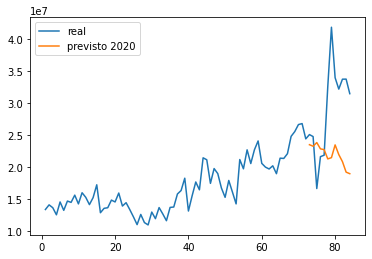

In [14]:
y_todos_anos = dataset[:,-1:]

X_sem_Y_2020 = dataset[72:84,:6]

y_2020 = array(y_pred).reshape(12,1)

novo_2020 = np.hstack((X_sem_Y_2020,y_2020))

dataset_pred = np.vstack((dataset[:72],novo_2020))

dados_pred = scaler.inverse_transform(dataset_pred)

y_dados_pred_2020 = dados_pred[72:84,-1:]

dados = scaler.inverse_transform(dataset)

y_todos_anos = dados[:,-1:]

y_todos_anos = y_todos_anos.reshape(84,)
y_dados_pred_2020 = y_dados_pred_2020.reshape(12,)

d_total = list(range(1,85))
d_2020 = list(range(73,85))
plt.plot(d_total, y_todos_anos, label='real')
plt.plot(d_2020,y_dados_pred_2020, label='previsto 2020')
plt.legend()
plt.show() 

(48, 12, 6) (48,)
2/2 [==============================] - 0s 4ms/step - loss: 4.5202e-11


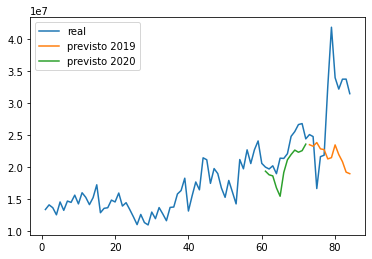

In [15]:

# dados de 2014 até final 2018
train = dataset[0:60]
y_2018 = dataset[60:72,-1]

X, y = split_sequences(train, n_steps)

print(X.shape, y.shape)

# the dataset knows the number of features
n_features = X.shape[2]


modelos_19 = {}
for i in range (0,100):
    model = Sequential() 
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu' , input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2)) 
    model.add(Flatten()) 
    model.add(Dense(50, activation='relu' )) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam' , loss='mse' )
    model.fit(X, y, epochs=1000, verbose=0)
    score = model.evaluate(X, y)
    modelos_19[i] = (model,score)

rank_modelos_19 = sorted(modelos_19.keys(), key=lambda x: modelos_19[x][1]) 

best = rank_modelos_19[0]

model_19, model_loss_19 = modelos_19[best] #modelo com a menor perda


begin_ix = 60-n_steps #72 é posição onde está janeiro 2019
dataset_X_pred = dataset[begin_ix:71, :-1] #71 é novembro, pois max que vamos é até dez/19

X_pred = split_sequences_pred(dataset_X_pred , n_steps)
#começa em -1 e vai diminuindo
y_pred_19 = list()
for i in range(12):
    X=X_pred[-1-i].reshape(1,n_steps,n_features)
    yhat = model_19.predict(X, verbose=0)
    y_pred_19.append(yhat[0][0])


y_2019 = array(y_pred_19).reshape(12,1)

dataset[:60]

d = np.hstack((dataset[60:72,:6],y_2019))

dataset[72:84]

dataset_novo = np.vstack((dataset[:60],d,dataset[72:84]))

dados_2019pred = scaler.inverse_transform(dataset_novo)

y_dados_pred_2019 = dados_2019pred[60:72,-1:]

y_dados_pred_2019 = y_dados_pred_2019.reshape(12,)






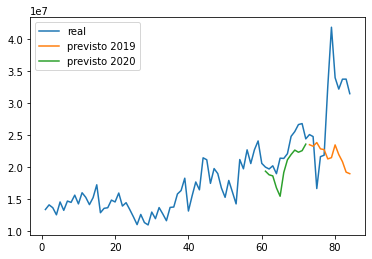

In [19]:
d_total = list(range(1,85))
d_2020 = list(range(73,85))
d_2019 = list(range(61,73))
plt.plot(d_total, y_todos_anos, label='real')
plt.plot(d_2020,y_dados_pred_2020, label='previsto 2019')
plt.plot(d_2019,y_dados_pred_2019,label='previsto 2020')
plt.legend()
plt.show() 

In [16]:
#model.save("adp255/datasets/cnn_20.h5")
#model = keras.models.load_model("adp255/datasets/cnn_20.h5")

In [17]:
#model_19.save("adp255/datasets/cnn_19.h5")

In [18]:
#model.save("adp255/datasets/cnn_100_20.h5")
#model_19.save("adp255/datasets/cnn_100_19.h5")